In [21]:
# 加载模型
import torch
from stable_baselines3 import DQN

model = DQN.load("./model/SACE_dqn_model",device='cpu')
model_lane_change = model.policy.q_net.q_net
torch.save(model_lane_change, 'model_lane_change')
data = torch.load("./data/SACE_dqn_data.pth")
data_x = torch.stack(data)

You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.


In [22]:
from FullyNet_Shapleyflowtest import FullyNet_Shapleyflow

In [23]:
# max_indices = torch.argmax(model_lane_change(data_x), dim=1)
# 找到每组输出的最大值及其索引
max_values, max_indices = torch.max(model_lane_change(data_x), dim=1) # 所有被选择的决策索引，及其输出值
# 找到最大值中的最小值的索引
min_indices_in_max_values = torch.argmin(max_values)  # 输出值最小的索引，正定基值点索引

In [24]:
# 3. 定义预测函数
def predict_fn(data):
    # 转换为 PyTorch 张量并进行预测
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        predictions = model_lane_change(data_tensor).numpy()
    return predictions

In [58]:
background = data_x[min_indices_in_max_values:min_indices_in_max_values + 1]
test_aa = FullyNet_Shapleyflow(model_lane_change, background)
pos_shap_value = test_aa.calculate_shapley_flow(data_x)

In [59]:
import shap
shap_kernel = shap.KernelExplainer(predict_fn, background.numpy())
shap_kernel_value = shap_kernel.shap_values(data_x.numpy())

  0%|          | 0/400 [00:00<?, ?it/s]

In [64]:
import numpy as np
acc_shap_kernel_value = shap_kernel_value[2]
pos_shap_value_list = [np.array(tensor) for tensor in pos_shap_value]
pos_shap_value_numpy = np.array(pos_shap_value_list)
acc_pos_shap_value_numpy = pos_shap_value_numpy[:,2,:]

In [65]:
max_indices = np.argmax(acc_shap_kernel_value, axis=1)

In [70]:
shap_row_max_values= acc_shap_kernel_value[np.arange(acc_shap_kernel_value.shape[0]), max_indices]

Posshap_row_max_values = acc_pos_shap_value_numpy[np.arange(acc_pos_shap_value_numpy.shape[0]), max_indices]

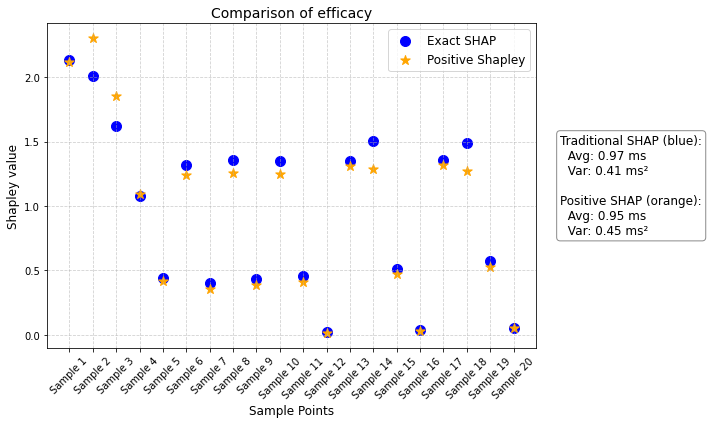

In [74]:
# Create the scatter plot again with coordinated side text
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
sample_points = np.arange(1, 21)  # 20 sample points
time_shap = np.random.uniform(80, 100, size=20)  # Simulated time for traditional SHAP
time_positive_shap = np.random.uniform(30, 50, size=20)

time_positive_shap = Posshap_row_max_values[0:20]
time_shap = shap_row_max_values[0:20]
# Calculate average and variance for both methods
avg_time_shap = np.mean(time_shap)
var_time_shap = np.var(time_shap)

avg_time_positive_shap = np.mean(time_positive_shap)
var_time_positive_shap = np.var(time_positive_shap)


plt.figure(figsize=(10, 6))
plt.scatter(sample_points, time_shap, marker='o', color='blue', label='Exact SHAP', s=100)
plt.scatter(sample_points, time_positive_shap, marker='*', color='orange', label='Positive Shapley', s=100)

# Set x-ticks to represent each sample point
plt.xticks(sample_points, [f"Sample {i}" for i in sample_points], rotation=45, fontsize=10)

# Add labels, title, and legend
plt.xlabel('Sample Points', fontsize=12)
plt.ylabel('Shapley value', fontsize=12)
plt.title('Comparison of efficacy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.6, linestyle='--')

# Add a side box showing averages and variances with matching colors
text_str = (f"Traditional SHAP (blue):\n"
            f"  Avg: {avg_time_shap:.2f} ms\n"
            f"  Var: {var_time_shap:.2f} ms²\n\n"
            f"Positive SHAP (orange):\n"
            f"  Avg: {avg_time_positive_shap:.2f} ms\n"
            f"  Var: {var_time_positive_shap:.2f} ms²")
plt.gca().text(1.05, 0.5, text_str, fontsize=12, transform=plt.gca().transAxes,
               verticalalignment='center', bbox=dict(boxstyle="round", facecolor="white",
                                                     edgecolor="gray", alpha=0.9))

# Adjust the layout to align the text with the height of the plot
plt.tight_layout()
file_path = "./figure/efficacy.svg"
plt.savefig(file_path, format='svg')

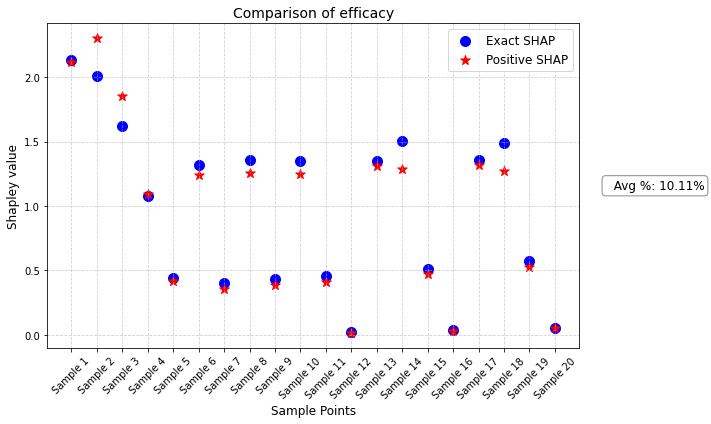

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 pos_time_list 和 shap_time_list 是您之前计算好的两个时间列表
# pos_time_list = [...]  # Positive Shapley 时间列表
# shap_time_list = [...]  # Traditional SHAP 时间列表

# Data for the plot
sample_points = np.arange(1, 21)  # 20 sample points
# time_shap = np.array(shap_time_list)  # Traditional SHAP 时间
# time_positive_shap = np.array(pos_time_list)  # Positive Shapley 时间

# Calculate average and variance for both methods
avg_time_shap = np.mean(time_shap)
var_time_shap = np.var(time_shap)

avg_time_positive_shap = np.mean(time_positive_shap)
var_time_positive_shap = np.var(time_positive_shap)

# Calculate the absolute difference and the percentage of the exact SHAP value
diff_time = np.abs(time_shap - time_positive_shap)
percentage_of_exact_shap = (diff_time / time_shap) * 100
avg_percentage_of_exact_shap = np.mean(percentage_of_exact_shap)

plt.figure(figsize=(10, 6))
plt.scatter(sample_points, time_shap, marker='o', color='blue', label='Exact SHAP', s=100)
plt.scatter(sample_points, time_positive_shap, marker='*', color='r', label='Positive SHAP', s=100)

# Set x-ticks to represent each sample point
plt.xticks(sample_points, [f"Sample {i}" for i in sample_points], rotation=45, fontsize=10)

# Add labels, title, and legend
plt.xlabel('Sample Points', fontsize=12)
plt.ylabel('Shapley value', fontsize=12)
plt.title('Comparison of efficacy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.6, linestyle='--')

# Add a side box showing averages, variances, and the indicator with matching colors
text_str = (
            f"  Avg %: {avg_percentage_of_exact_shap:.2f}%")
plt.gca().text(1.05, 0.5, text_str, fontsize=12, transform=plt.gca().transAxes,
               verticalalignment='center', bbox=dict(boxstyle="round", facecolor="white",
                                                     edgecolor="gray", alpha=0.9))

# Adjust the layout to align the text with the height of the plot
plt.tight_layout()
file_path = "./figure/efficacy.svg"
plt.savefig(file_path, format='svg')

## 循环计算20个点的Shapley